In [1]:
#set a few things before running the analysis

#number of segments in lines
num_segs_line1=15


#column location of roll pitch yaw rotation in KiteFAST.out
roll_col=1
pitch_col=2
yaw_col=3

#column location of Fx,FY,FZ (global integrated aero loads) in the KiteFAST.out
kf_fx_col=4
kf_fy_col=5
kf_fz_col=6


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

#Analyzing the KiteTether forces

#load the line geometry files
line1_geo_pd=pd.read_csv('KiteFast.MD.MD.Line1.out',skiprows=2,delim_whitespace=True)
line1_geo=line1_geo_pd.values


#load the force MD force measurements
MD_loads_pd=pd.read_csv('KiteFast.MD.MD.out',skiprows=2,delim_whitespace=True)
MD_loads=MD_loads_pd.values

#load the KiteFAST output file
KF_pd=pd.read_csv('KiteFast.out',skiprows=7,delim_whitespace=True)
KF=KF_pd.values

#load the CSim results
xls = pd.ExcelFile("CSim_output_noturb_20181204.xlsx")
sheetX = xls.parse(0) #this the sheet number
CStime = sheetX['time']
CSimFX = sheetX['wing_fx']
CSimFY = sheetX['wing_fy']
CSimFZ = sheetX['wing_fz']
CSimFXaero = sheetX['tether_fx']
CSimFYaero = sheetX['tether_fy']
CSimFZaero = sheetX['tether_fz']
CSimFaxS = sheetX['loadcell_P_A']
CSimFaxP = sheetX['loadcell_S_A']
CSimFXAER = sheetX['wing_aero_fx']
CSimFYAER = sheetX['wing_aero_fy']
CSimFZAER = sheetX['wing_aero_fz']


lc_min=min(line1_geo.shape[0], MD_loads.shape[0])
#lc_min=100

tether_force_local_report=np.zeros([lc_min+1,4])
aero_force_local_report=np.zeros([lc_min+1,4])

#compute the FX,FY and FZ components for each line at each time step
lc=-1
while lc<(lc_min-1):
    lc=lc+1
    cur_time=MD_loads[lc,0]

    
    #get the current euler angles from the KF output
    roll_ang=np.interp(cur_time, KF[:,0], KF[:,roll_col])
    pitch_ang=np.interp(cur_time, KF[:,0], KF[:,pitch_col])
    yaw_ang=np.interp(cur_time, KF[:,0], KF[:,yaw_col])
    
    #get the integrated aero loads (global coordinate system) from the KF output 
    fx_aerog=np.interp(cur_time, KF[:,0], KF[:,kf_fx_col])
    fy_aerog=np.interp(cur_time, KF[:,0], KF[:,kf_fy_col])
    fz_aerog=np.interp(cur_time, KF[:,0], KF[:,kf_fz_col])
    
    #compute DCM from euler angles
    r = R.from_euler('XYZ', [roll_ang, pitch_ang, yaw_ang], degrees=True)
    dcm=r.as_dcm()
    

    #transform the integrated aero loads to the kite coordinate system
    global_aero_force=np.matrix([fx_aerog, fy_aerog, fz_aerog])
    local_aero_force=np.matmul(np.transpose(dcm),np.transpose(global_aero_force))
    aero_force_local_report[lc,0]=cur_time
    aero_force_local_report[lc,1]=local_aero_force[0]
    aero_force_local_report[lc,2]=local_aero_force[1]
    aero_force_local_report[lc,3]=local_aero_force[2]
    


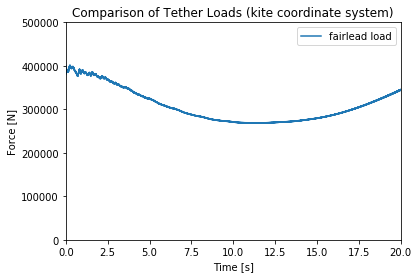

In [7]:
#plot the tether loads 
%matplotlib inline
plt.plot(MD_loads[:,0],MD_loads[:,1],label='fairlead load')
plt.legend()
plt.title('Comparison of Tether Loads (kite coordinate system)')
plt.ylabel('Force [N]')
plt.xlabel('Time [s]')
plt.xlim([0.0, 20.0])
plt.ylim([0, 500E3])
plt.show()